In [2]:
%matplotlib inline

## Exposures and color channels

### rgb-grayscale
- convert rgb to single grayscale channel
- conversion = weighted sum: .2125*R + .7154*G + .0721*B 
- this formula used by CRT phosphors (best? model of human perception)

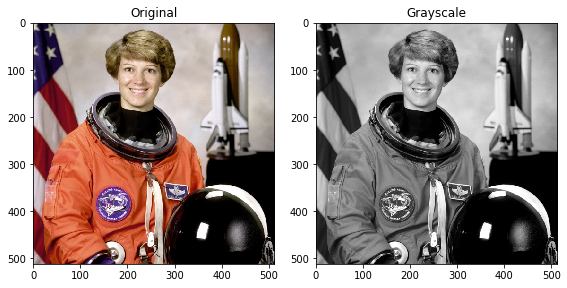

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage       import data
from skimage.color import rgb2gray

original, grayscale = data.astronaut(), rgb2gray(original)

# --------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")

fig.tight_layout()
plt.show()

### rgb-hsv (hue/sat/value)
- [https://en.wikipedia.org/wiki/HSL_and_HSV](Wikipedia)
    - colors of each hue are arranged in a radial slice, around a central axis of neutral colors which ranges from black at the bottom to white at the top.
    - HSV representation models how paints of different colors mix together, with "saturation" resembling various tints of brightly colored paint, and "value" resembling the mixture of those paints with varying amounts of black or white paint. 
    
- in RGB: hue, luminosity = linear combo of R,G,B channels
- in HSV: hue, luminosity = single channels
- image segmentation can be done by thresholding the HSV channels

In [10]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hsv

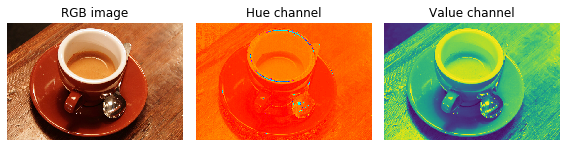

In [13]:
# first load RGB image -- extract Hue & Value channels

rgb_img   = data.coffee()
hsv_img   = rgb2hsv(rgb_img)
hue_img   = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

# ------------------------------------------------------------

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

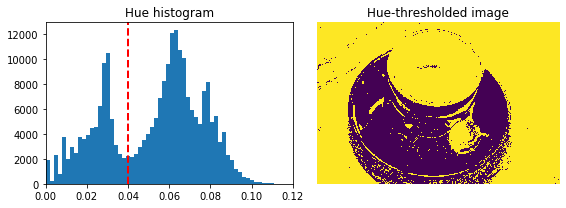

In [14]:
# set a threshold on hue channel to separate cup from background.

hue_threshold = 0.04
binary_img    = hue_img > hue_threshold

# ----------------------------------------------------------------------

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(hue_img.ravel(), 512)
ax0.set_title("Hue histogram")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(0, 0.12)
ax1.imshow(binary_img)
ax1.set_title("Hue-thresholded image")
ax1.axis('off')

fig.tight_layout()

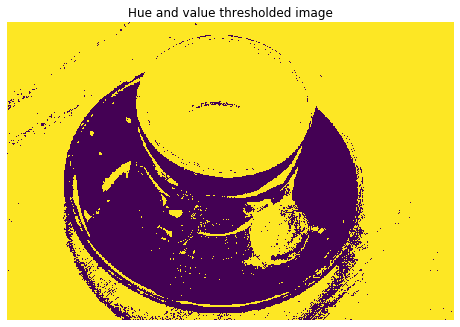

In [17]:
value_threshold = 0.10
binary_img = (hue_img > hue_threshold) | (value_img < value_threshold)

# --------------------------------------------------------------------

fig, ax0 = plt.subplots(figsize=(8,6))
ax0.imshow(binary_img)
ax0.set_title("Hue and value thresholded image")
ax0.axis('off')

#fig.tight_layout()
plt.show()

### histogram matching 
- manipulates input channel pixels so its histogram matches a reference image
- if multiple channels, then per-channel matching
- can be used for lightweight normalization in image operations, eg feature matching

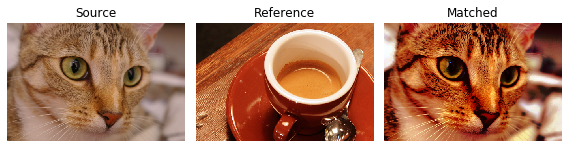

In [19]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

reference, image = data.coffee(), data.chelsea()
matched          = match_histograms(image, reference, multichannel=True)

# --------------------------------------------------------------------

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

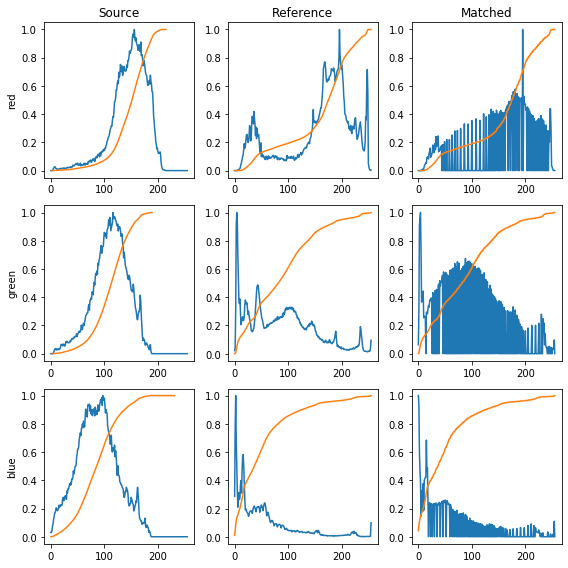

In [20]:
# illustrates effects of histogram matching
# - plots histogram & cume histogram for each RGB channel
# - matched image has same cumulative histogram as reference img per channel

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))


for i, img in enumerate((image, reference, matched)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max())
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf)
        axes[c, 0].set_ylabel(c_color)

axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Matched')

plt.tight_layout()
plt.show()

### immunohistochemical (IHC) staining colors separation
- color deconvolution: separating features by color
- IHC of FHL2 protein (brown color = presence of Diaminobenzidine (DAB))

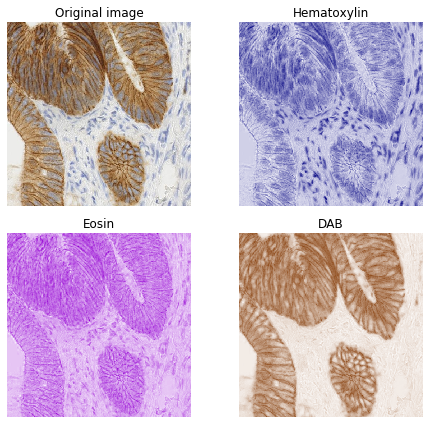

In [21]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

ihc_rgb = data.immunohistochemistry()
ihc_hed = rgb2hed(ihc_rgb)

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_hed[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")

ax[3].imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

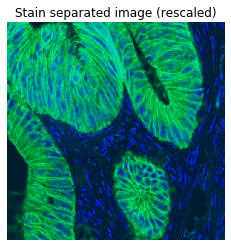

In [22]:
# now, manipulate hematoxylin & DAB channels

import numpy as np
from skimage.exposure import rescale_intensity

# Rescale hematoxylin and DAB signals and give them a fluorescence look

h   = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1))
d   = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1))
zdh = np.dstack((np.zeros_like(h), d, h))

# ----------------------------------------------------------
fig = plt.figure()
axis = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axis.imshow(zdh)
axis.set_title("Stain separated image (rescaled)")
axis.axis('off')
plt.show()

### adapting grayscale filters to rgb images
- many filters designed to work with grayscale - but not color
- _adapt_rgb()_ = decorator
- adapting RGB for grayscale filter use = two options:
    - each_channel (pass each channel to filter 1-by-1, stitch results)
    - hsv_value (convert to HSV, pass value channel to filter)

In [23]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

Text(0.5, 1.0, 'Sobel filter computed\n on (V)alue converted image (HSV)')

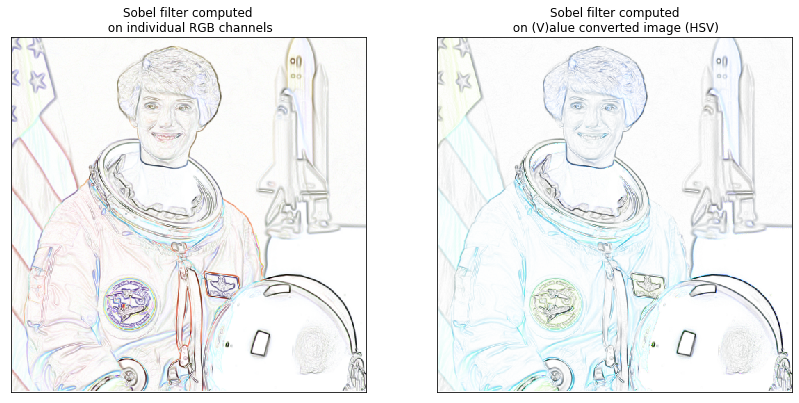

In [24]:
# now these functions work with both grayscale & color images
# plot results with color image.

from skimage import data
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

image = data.astronaut()

# --------------------------------------------------------------

fig, (ax_each, ax_hsv) = plt.subplots(ncols=2, figsize=(14, 7))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Sobel filter computed\n on individual RGB channels")

# We use 1 - sobel_hsv(image) but this won't work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

In [25]:
# create your own handler functions for _adapt_rgb_

def handler(image_filter, image, *args, **kwargs):
    # Manipulate RGB image here...
    image = image_filter(image, *args, **kwargs)
    # Manipulate filtered image here...
    return image

In [26]:
# simple example: convert any RGB image to grayscale & return filtered result.

from skimage.color import rgb2gray

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

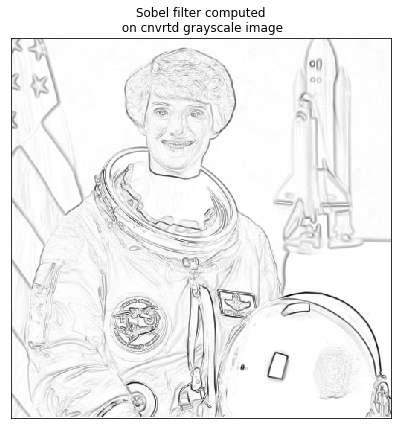

In [27]:
# now, use this handler with _adapt_rgb_ as before.

@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)

# ----------------------------------------------------------------------------

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))
# We use 1 - sobel_gray(image) but this won't work if image is not normalized
ax.imshow(rescale_intensity(1 - sobel_gray(image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Sobel filter computed\n on cnvrtd grayscale image")
plt.show()

- _adapt_rgb not recommended for functions supporting 3D volumes or non-RGB schemes.

### filtering regional maxima (bright features)
- here we use morphological reconstruction to build a background image
- subtract background from original to isolate bright features
- start by dilation at image edges
- build a seed image to min intensity; set border to pixel vals in original.
- max pixels will be dilated during reconstruction.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

# Convert to float: Important for subtraction later which won't work with uint8
image = img_as_float(data.coins())
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

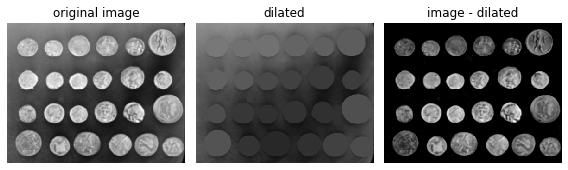

In [30]:
# subtracting dilated image leaves the coins against flat black background.

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

In [31]:
# coins surrounded by bright background in original = dimmer in subtracted image.
# use image itself as a reconstruction seed.
h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method='dilation')
hdome = image - dilated

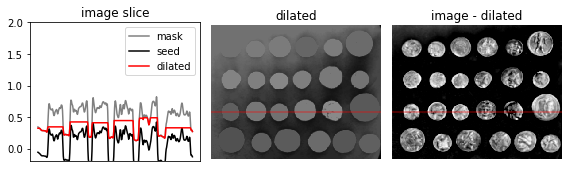

In [32]:
# plot mask intensity, seed, dilated images + slice of image (red line)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

### local histogram equalization (LHE)
- enhances an image with low contrast using LHE
- spreads out most frequent intensity values in a range

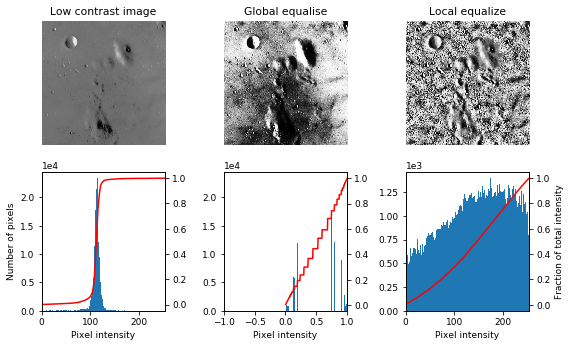

In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage            import data
from skimage.util.dtype import dtype_range
from skimage.util       import img_as_ubyte
from skimage            import exposure
from skimage.morphology import disk
from skimage.filters    import rank


matplotlib.rcParams['font.size'] = 9

def plot_img_and_hist(image, axes, bins=256):
    # Plot image with its histogram, cume histogram.

    ax_img, ax_hist = axes
    ax_cdf          = ax_hist.twinx()

    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    ax_hist.hist(image.ravel(), bins=bins)    # Display histogram
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

                                              # Display cume distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf

img         = img_as_ubyte(data.moon()) # Load an example image
img_rescale = exposure.equalize_hist(img)# Global equalize
selem       = disk(30)# Equalization
img_eq      = rank.equalize(img, selem=selem)

# -----------------------------------------------------------------------

fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')
 
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### gamma & log-contrast adjustments
- adjusts image contrast with 1) Gamma, 2) Logarithmic correction to input image.

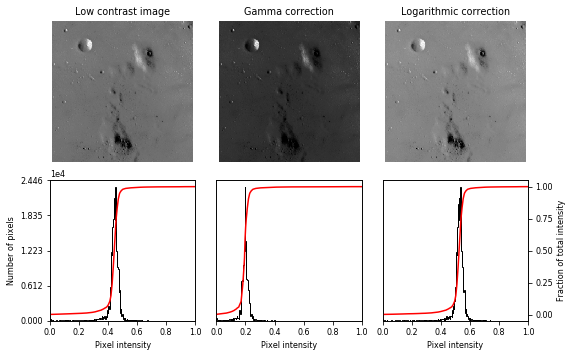

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8

# ---------------------------------------------------------------------
def plot_img_and_hist(image, axes, bins=256):
    #Plot image, histogram, cume histogram.
    
    image           = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf          = ax_hist.twinx()

    ax_img.imshow(image, cmap=plt.cm.gray)    # Display image
    ax_img.set_axis_off()

    ax_hist.hist(                             # Display histogram
        image.ravel(), 
        bins=bins, 
        histtype='step', 
        color='black')
    
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

img                   = data.moon()                   # Load an example image
gamma_corrected       = exposure.adjust_gamma(img, 2) # Gamma
logarithmic_corrected = exposure.adjust_log(img, 1)   # Logarithmic

# -----------------------------------------------------------------------------

fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### [histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization)
- enhance image with low contrast using HE (spreads most frequent intensities in an image).
- HE doesn't require params - sometimes leads to weird results.
- alternative: _contrast stretching_ (image rescaled to include all intensities btwn 2nd, 98th percentiles)

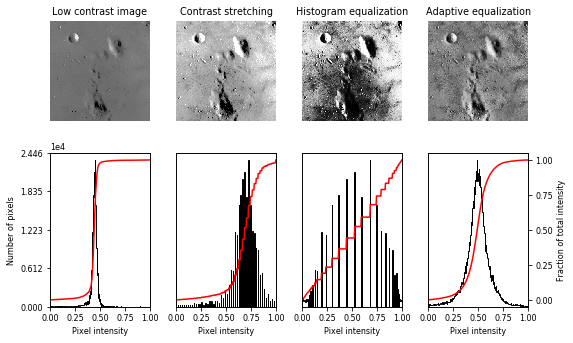

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    #Plot image, histogram, cume histogram.

    image           = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf          = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
# Contrast stretching
# Equalization
# Adaptive Equalization

img         = data.moon()
p2, p98     = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
img_eq      = exposure.equalize_hist(img)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# ---------------------------------------------------------------

fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

### tinting grayscale images
- use case: artificially tint an image
- below: scales RGB values & adjusting HSV params
- 2D: images often represented in RGB - 3 layers of 2D arrays
- simplest way to "tint" = set each RGB channel to the grayscale image, scaled by a distince multiplier for each channel, (eg, setting G,B to 0 Red; setting B to 0 leaves red & green = yellow.)

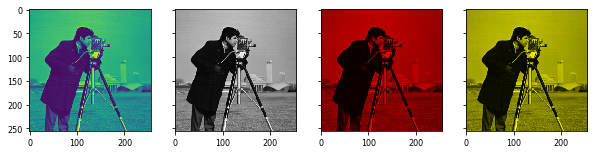

In [42]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import color
from skimage import img_as_float

grayscale_image   = img_as_float(data.camera()[::2, ::2])
gray2rgb_image    = color.gray2rgb(grayscale_image)
red_multiplier    = [1, 0, 0]
yellow_multiplier = [1, 1, 0]

# -------------------------------------------------------
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4),
#                               sharex=True, sharey=True)

fig, (gs,ax0,ax1,ax2) = plt.subplots(ncols=4, figsize=(10,5),
                                 sharex=True, sharey=True)

gs.imshow(grayscale_image)
ax0.imshow(gray2rgb_image)
ax1.imshow(red_multiplier * image)
ax2.imshow(yellow_multiplier * image)

- if RGB not preferred option, HSV (hue, saturation, value=brightness) is an alternative.
- hue,sat,val share the same datatype (float, 0.0-1.0).
- some formats use hue = 0-360.
- below: plot linear gradient in the hue (saturation, value turned up)

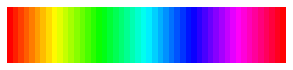

In [44]:
import numpy as np

hue_gradient = np.linspace(0, 1)
hsv          = np.ones(shape=(1, len(hue_gradient), 3), dtype=float)
hsv[:, :, 0] = hue_gradient

all_hues = color.hsv2rgb(hsv)

# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(5, 2))
# Set image extent so hues go from 0 to 1 
# and the image is a nice aspect ratio.
ax.imshow(all_hues, extent=(0, 1, 0, 0.2))
ax.set_axis_off()

- notice: colors at far left, far right = the same. (this is the hue wraparound.)
- below: utility function:
    - accepts RGB image
    - transforms it to HSV 
    - sets hue & sat
    - transforms back to RGB

In [45]:
def colorize(image, hue, saturation=1):
    hsv = color.rgb2hsv(image)
    hsv[:, :, 1] = saturation
    hsv[:, :, 0] = hue
    return color.hsv2rgb(hsv)

- plot six images, linear gradient in the hue, "vintage" saturation

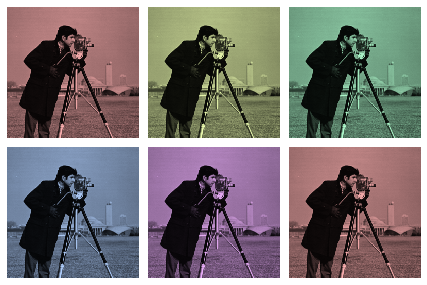

In [46]:
hue_rotations = np.linspace(0, 1, 6)

fig, axes = plt.subplots(nrows=2, ncols=3, 
                         sharex=True, sharey=True)

for ax, hue in zip(axes.flat, hue_rotations):
    # Turn down the saturation to give it that vintage look.
    tinted_image = colorize(image, hue, saturation=0.3)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
fig.tight_layout()
plt.show()

- combine tinting with numpy slicing & fancy indexing for _selective_ tinting.
- below: set hue of "some" rectangles, scale RGB values of thresholded pixels.

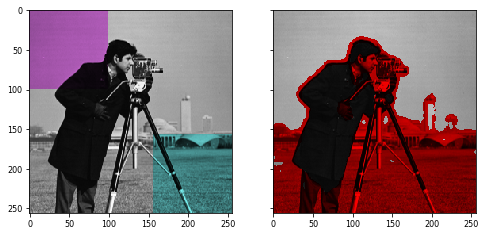

In [48]:
from skimage.filters import rank

# Square regions defined as slices over the first two dimensions.
top_left                   = (slice(100),) * 2
bottom_right               = (slice(-100, None),) * 2
sliced_image               = image.copy()
sliced_image[top_left]     = colorize(image[top_left],     0.82, saturation=0.5)
sliced_image[bottom_right] = colorize(image[bottom_right], 0.5,  saturation=0.5)

# Create a mask selecting regions with interesting texture.
noisy                      = rank.entropy(grayscale_image, np.ones((9, 9)))
textured_regions           = noisy > 4

# Note that using `colorize` here is a bit more difficult, since `rgb2hsv`
# expects an RGB image (height x width x channel), but fancy-indexing returns
# a set of RGB pixels (# pixels x channel).

masked_image                       = image.copy()
masked_image[textured_regions, :] *= red_multiplier

# --------------------------------------------------------------------------

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                               sharex=True, sharey=True)
ax1.imshow(sliced_image)
ax2.imshow(masked_image)

plt.show()